In [1]:
import gc

gc.enable()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

import lightgbm as lgb

import os
import os.path
# print(os.listdir("../input"))

# credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
by_team = ['matchId','groupId']

In [3]:
random_seed = 15305
df_train = None

if not os.path.isfile('train_V2_solo.csv'):
    print('Solo file not exists, load all')
    df_train = pd.read_csv('train_V2.csv')
    df_train = reduce_mem_usage(df_train)
    df_train = df_train[df_train['winPlacePerc'].isna() != True]
    mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
    
#     df_train['matchType'].value_counts().plot.bar()
    
    df_train['matchType'] = df_train['matchType'].apply(mapper)
    
    old_size = df_train.shape[0]
    
    df_train = df_train[df_train['matchType'] == 'solo']
    
    print('Reduced size from ', old_size, ' to ', df_train.shape[0])
    
    df_train.to_csv('train_V2_solo.csv', index=False)
    
else:
    df_train = pd.read_csv('train_V2_solo.csv')
    df_train = reduce_mem_usage(df_train)
    print('Solo file exists, loaded, size: ', df_train.shape[0])
        

gc.collect()

Solo file exists, loaded, size:  720712


7

In [4]:
df_train.describe(include=np.number).drop('count').T

,mean,std,min,25%,50%,75%,max
assists,0.062236,0.297540,0.0,0.000000,0.000000,0.000000,22.0
boosts,1.059862,1.799456,0.0,0.000000,0.000000,2.000000,28.0
damageDealt,NaN,NaN,0.0,0.000000,74.375000,169.250000,6616.0
DBNOs,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
headshotKills,0.249281,0.660425,0.0,0.000000,0.000000,0.000000,42.0
heals,1.014149,2.406086,0.0,0.000000,0.000000,1.000000,63.0
killPlace,47.457529,27.728956,1.0,23.000000,47.000000,71.000000,100.0
killPoints,447.426431,594.989089,0.0,0.000000,0.000000,1090.000000,1970.0
kills,0.936860,1.603249,0.0,0.000000,0.000000,1.000000,66.0
killStreaks,0.475054,0.564241,0.0,0.000000,0.000000,1.000000,18.0


In [5]:
df_train.drop('DBNOs',  axis =1,inplace= True)
df_train.drop('revives',  axis =1,inplace= True)

In [7]:
df_train['maxPlace'].describe()

count    720712.000000
mean         93.908900
std          10.134818
min           2.000000
25%          94.000000
50%          96.000000
75%          97.000000
max         100.000000
Name: maxPlace, dtype: float64

In [6]:

def feature_engineering(df, is_train=True):
    test_idx = None
    if not is_train: 
        print("processing test")
        test_idx = df.Id
    else:
        print("processing train")

    
    print("remove some columns")
    target = 'winPlacePerc'

    print("Adding Features")
    

    
    df['headshotrate'] = df['kills']/ (df['headshotKills'] )
    df['killStreakrate'] = df['killStreaks']/ (df['kills'] )
    df['healthitems'] = df['heals'] + df['boosts']
    df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    df['killPlace_over_maxPlace'] = df['killPlace'] / (df['maxPlace'] )
    
    df['distance_over_weapons'] = df['totalDistance'] / (df['weaponsAcquired'] )
    df['walkDistance_over_heals'] = df['walkDistance'] / (df['heals'] )
    df['walkDistance_over_kills'] = df['walkDistance'] / (df['kills'] )
    df['killsPerWalkDistance'] = df['kills'] / (df['walkDistance'] )
    
    

    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    
    print("Removing Na's From DF")
    df.fillna(0, inplace=True)

    
    features = list(df.columns)
    features.remove("Id")

    features.remove(target)
    features.remove("matchId")
    
    features.remove("groupId")
    features.remove("matchType")
    
    
    
    return df[features], df[target], features, test_idx
    

In [7]:

import warnings
warnings.filterwarnings("ignore")

X_train, X_holdout, y_train, y_holdout = train_test_split(df_train, df_train['winPlacePerc'], test_size=0.1,
random_state=random_seed)


X_train, y_train, columns, _ = feature_engineering(X_train, True)
X_train = reduce_mem_usage(X_train)


X_holdout, _, _ ,_ = feature_engineering(X_holdout, False)

train_index = round(int(X_train.shape[0]*0.9))
dev_X = X_train[:train_index] 
val_X = X_train[train_index:]
dev_y = y_train[:train_index] 
val_y = y_train[train_index:] 
gc.collect()

gc.collect()
print(dev_X.shape, val_X.shape)

processing train
remove some columns
Adding Features
Removing Na's From DF
processing test
remove some columns
Adding Features
Removing Na's From DF
(583776, 31) (64864, 31)


In [12]:
print(X_train.shape, X_holdout.shape)

(648640, 36) (72072, 36)


In [8]:



model_name = 'model_lgb.txt'

def run_lgb(train_X, train_y, val_X, val_y, x_test):
    params = {"objective" : "regression", "metric" : "mae", 'n_estimators':10000,
              'early_stopping_rounds':300,
              "num_leaves" : 31, "learning_rate" : 0.05, 
              "bagging_fraction" : 0.7,
               "bagging_seed" : 0, "num_threads" : 4,"colsample_bytree" : 0.7
             }
    model = None
    
    if not os.path.isfile(model_name):
        print(model_name, ' not found, start train ;-(')
        lgtrain = lgb.Dataset(train_X, label=train_y)
        lgval = lgb.Dataset(val_X, label=val_y)
        model = lgb.train(params, lgtrain, valid_sets=[lgtrain, lgval], verbose_eval=1000)
        model.save_model(model_name)
        
    else:
        print(model_name, ' found, start predict ;-)')
        model = lgb.Booster(model_file=model_name)
        
    
    pred_test_y = model.predict(x_test, num_iteration=model.best_iteration)
    return pred_test_y, model

# Training the model #
pred_test, model = run_lgb(dev_X, dev_y, val_X, val_y, X_holdout)
gc.collect()

model_lgb.txt  not found, start train ;-(
Training until validation scores don't improve for 300 rounds.
[1000]	training's l1: 0.039217	valid_1's l1: 0.0400024
[2000]	training's l1: 0.0380354	valid_1's l1: 0.0395616
[3000]	training's l1: 0.0371256	valid_1's l1: 0.0393314
[4000]	training's l1: 0.0363148	valid_1's l1: 0.0391348
[5000]	training's l1: 0.0356025	valid_1's l1: 0.0389988
[6000]	training's l1: 0.0349183	valid_1's l1: 0.0388675
[7000]	training's l1: 0.0342881	valid_1's l1: 0.0387799
[8000]	training's l1: 0.0336253	valid_1's l1: 0.0386508
[9000]	training's l1: 0.0330617	valid_1's l1: 0.0385864
[10000]	training's l1: 0.0325192	valid_1's l1: 0.0385194
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.0325192	valid_1's l1: 0.0385194


24

In [9]:
pred_y = pred_test.copy()
df_sub = X_holdout.copy()
gc.collect()
df_sub.head()

,assists,boosts,damageDealt,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,...,winPoints,headshotrate,killStreakrate,healthitems,totalDistance,killPlace_over_maxPlace,distance_over_weapons,walkDistance_over_heals,walkDistance_over_kills,killsPerWalkDistance
252538,0,0,0.00,0,0,96,1670,0,0,0.00000,...,1453,0.0,0.0,0,0.0,1.000000,0.000,0.0,0.0,0.000000
443955,0,0,0.00,0,4,57,0,0,0,0.00000,...,0,0.0,0.0,4,0.0,1.055556,0.000,0.0,0.0,0.000000
134536,0,1,0.00,0,0,58,0,0,0,0.00000,...,0,0.0,0.0,1,2156.0,0.604167,308.000,0.0,0.0,0.000000
663320,0,5,205.75,0,3,13,0,2,1,304.25000,...,0,0.0,0.5,8,4440.0,0.134021,888.000,1480.0,2220.0,0.000450
56745,0,0,100.00,0,0,33,0,1,1,5.84375,...,0,0.0,1.0,0,329.5,0.354839,82.375,0.0,329.5,0.003035


In [10]:
print("MAE: ",
mean_absolute_error(y_holdout, pred_y) )

print("MSE: ",
mean_squared_error(y_holdout, pred_y))

MAE:  0.03863669974825324
MSE:  0.003354791245559458


In [11]:
fi = model.feature_importance(importance_type='gain')
fn = model.feature_name()
fi = fi / fi.max() * 100

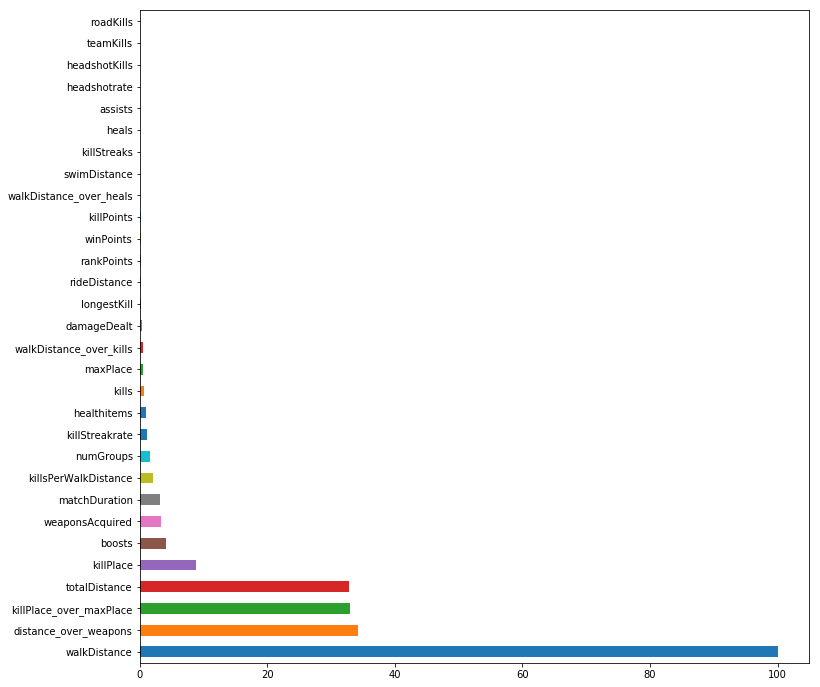

In [12]:
feat_importances = pd.Series(fi, index=fn)
feat_importances.nlargest(30).plot(kind='barh', figsize=(12,12))

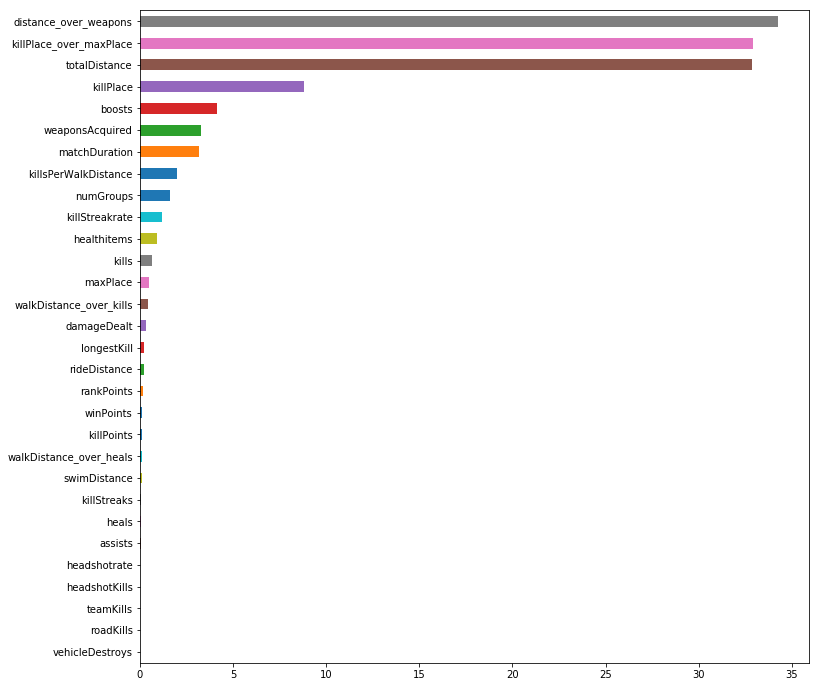

In [13]:
feat_importances.nsmallest(30).plot(kind='barh', figsize=(12,12))

# xgboost

In [15]:
import xgboost

In [16]:
xgb = xgboost.XGBRegressor(
    n_estimators=700,
    max_depth=11,
    disable_default_eval_metric=1,
    
    subsample=0.9,
    colsample_bytree=0.9,
    learning_rate=0.05,
    n_jobs=4
    )
xgb.fit(dev_X, dev_y,
        eval_set=[(val_X, val_y)], eval_metric='mae',
        early_stopping_rounds=100)

[0]	validation_0-mae:0.246329
Will train until validation_0-mae hasn't improved in 100 rounds.
[1]	validation_0-mae:0.234541
[2]	validation_0-mae:0.223391
[3]	validation_0-mae:0.212804
[4]	validation_0-mae:0.202784
[5]	validation_0-mae:0.193287
[6]	validation_0-mae:0.184306
[7]	validation_0-mae:0.175872
[8]	validation_0-mae:0.167798
[9]	validation_0-mae:0.160164
[10]	validation_0-mae:0.152985
[11]	validation_0-mae:0.146161
[12]	validation_0-mae:0.139752
[13]	validation_0-mae:0.133673
[14]	validation_0-mae:0.127964
[15]	validation_0-mae:0.122541
[16]	validation_0-mae:0.117445
[17]	validation_0-mae:0.112612
[18]	validation_0-mae:0.108061
[19]	validation_0-mae:0.103798
[20]	validation_0-mae:0.099768
[21]	validation_0-mae:0.096024
[22]	validation_0-mae:0.092451
[23]	validation_0-mae:0.089104
[24]	validation_0-mae:0.085999
[25]	validation_0-mae:0.083055
[26]	validation_0-mae:0.080299
[27]	validation_0-mae:0.077732
[28]	validation_0-mae:0.075296
[29]	validation_0-mae:0.07304
[30]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, disable_default_eval_metric=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=11,
       min_child_weight=1, missing=None, n_estimators=700, n_jobs=4,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9)

In [17]:
xgb_y_pred = xgb.predict(X_holdout)

In [19]:
print("MAE: ",
mean_absolute_error(y_holdout, xgb_y_pred) )

print("MSE: ",
mean_squared_error(y_holdout, xgb_y_pred))



MAE:  0.03855465
MSE:  0.0033740627


## я сохранил, загрузишь сама, если понадобится

In [20]:
xgb.save_model('model_xgb')